# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

## Подготовка данных

Для начала загрузим требуемые нам библиотеки

### Общая информация

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV


from gensim.models import Word2Vec
import gensim.downloader

pd.options.mode.chained_assignment = None

Посмотрим общую информацию датафрейма для определения фронта работ

In [85]:
cars = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [86]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [87]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [88]:
cars.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


#### Выводы

- В колонке с количеством фотографий отсутствуют какие-либо значения;
- Все колонки формата datetime не помогут нам в обучении модели, их нужно будет удалить;
- Неправдоподобно выскоие или низкие значения наблюдаются в колонках мощности, года регистрации, цены,месяца регистрации;
- Придётся удалить колонку с кодом почтового отделения,т.к она нам тоже не поможет;
- В различных столбцах встречаются пропущенные значения,требуется заполнение,где это возможно.

### Предобработка данных

Для начала удалим колонку 'PostalCode',которая несёт данные о почтовых кодах размещения автотранспорта, т.к она не поможет нам в формировании модели. 

In [88]:
cars = cars.drop(['PostalCode'],axis=1)

Теперь переименуем колонки согласно правилам оформления

In [89]:
cars = cars.rename(columns = {'DateCrawled':'date_crawled','DateCreated':'date_created',
                            'LastSeen':'last_seen','VehicleType':'vehicle_type',
                            'RegistrationYear':'registration_year','RegistrationMonth':'registration_month',
                            'FuelType':'fuel','NotRepaired':'not_repaired','NumberOfPictures':'pictures'})

Остальные приведем к нижнему регистру

In [90]:
cars.columns = map(str.lower, cars.columns)

In [91]:
cars.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel,brand,not_repaired,date_created,pictures,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,2016-04-06 10:17:21


Так же в описании смущает столбец 'registration_year' c минимумом в 1000 и максимуме в 9999 годах

In [9]:
cars.registration_year.value_counts(ascending = True).head(30)

8455    1
1915    1
1919    1
1920    1
3200    1
1925    1
1927    1
1931    1
1688    1
2200    1
1946    1
7800    1
1949    1
5300    1
8888    1
7100    1
4800    1
3800    1
5600    1
1253    1
1255    1
1001    1
9450    1
1200    1
1400    1
3500    1
3700    1
4100    1
9996    1
9229    1
Name: registration_year, dtype: int64

Действительно,есть странные значения. Построим гистограмму

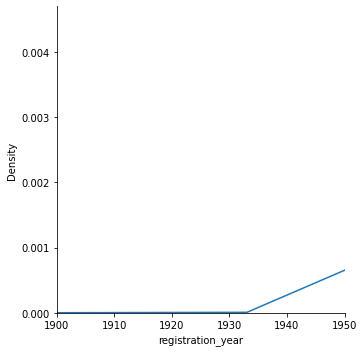

In [10]:
ax = sns.displot(cars, x="registration_year", kind="kde")
ax.set(xlim=(1900, 1950))

In [11]:
cars_f1 = cars[cars['registration_year'] <= 2016]

Так же посмотрим записи с 1900 по 1960

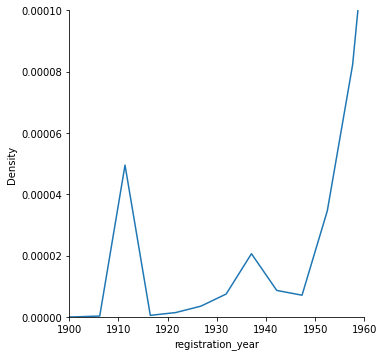

In [12]:
ax = sns.displot(cars_f1, x="registration_year", kind="kde")
ax.set(xlim=(1900, 1960))
ax.set(ylim=(0, 0.0001))

Посмотрим,сколько таких записей

In [13]:
cars_f1.loc[cars_f1['registration_year']<1950]['brand'].count()

246

Записей крайне мало,удалим записи до 1950

In [14]:
cars_n = cars_f1[cars_f1['registration_year']>1950]

Так же для построения модели нам не помогут колонки 'last_seen' и 'date_created', но будут замедлять процесс обучения. Их мы тоже удалим

In [92]:
cars_new = cars_n.drop(['last_seen', 'date_created'],axis=1)

In [93]:
cars_new.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel,brand,not_repaired,pictures
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0


Как мы видим, встречаются пропуски в колонке 'not_repaired'. По сути, никаким подбором или автозаполнением мы это заменить не сможем.Однако пропуски оставлять не стоит. Предлагаю просто указать, что информация неизвестна.

In [94]:
cars_new['not_repaired'] = cars_new['not_repaired'].fillna('unknown')

In [95]:
cars_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339575 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        339575 non-null  object
 1   price               339575 non-null  int64 
 2   vehicle_type        316735 non-null  object
 3   registration_year   339575 non-null  int64 
 4   gearbox             321764 non-null  object
 5   power               339575 non-null  int64 
 6   model               322046 non-null  object
 7   kilometer           339575 non-null  int64 
 8   registration_month  339575 non-null  int64 
 9   fuel                312416 non-null  object
 10  brand               339575 non-null  object
 11  not_repaired        339575 non-null  object
 12  pictures            339575 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 36.3+ MB


Так же удалим дубликаты

In [96]:
cars_new = cars_new.drop_duplicates()

Теперь займёмся пропусками в колонках  'model','brand' и 'vehicle_type'

In [97]:
cars_new['model'] = cars_new.groupby('brand')['model'].transform(lambda x:x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))
cars_new['brand'] = cars_new.groupby('model')['brand'].transform(lambda x:x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))

In [98]:
print(cars_new.loc[cars_new['brand'].isna() == True]['date_crawled'].count())
cars_new.loc[cars_new['model'].isna() == True]['date_crawled'].count()

0


0

In [99]:
cars_new['vehicle_type'] =cars_new.groupby(['model','brand'])['vehicle_type'].transform(lambda x:x.fillna((x.mode()[0] if not x.mode().empty else 'unknown')))

In [100]:
cars_new.loc[cars_new['vehicle_type'].isna() == True]['date_crawled'].count()

0

In [101]:
cars_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339550 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        339550 non-null  object
 1   price               339550 non-null  int64 
 2   vehicle_type        339550 non-null  object
 3   registration_year   339550 non-null  int64 
 4   gearbox             321739 non-null  object
 5   power               339550 non-null  int64 
 6   model               339550 non-null  object
 7   kilometer           339550 non-null  int64 
 8   registration_month  339550 non-null  int64 
 9   fuel                312391 non-null  object
 10  brand               339550 non-null  object
 11  not_repaired        339550 non-null  object
 12  pictures            339550 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 36.3+ MB


Посмотрим на пропуски в колонке 'fuel'

In [102]:
cars_new['fuel'].value_counts()

petrol      209896
gasoline     96290
lpg           5158
cng            542
hybrid         224
other          192
electric        89
Name: fuel, dtype: int64

In [103]:
cars_new[cars_new['fuel'].isna() == True]['registration_year'].count()

27159

In [104]:
cars_new['fuel'] = cars_new['fuel'].fillna(cars_new['fuel'].mode()[0])
cars_new[cars_new['fuel'].isna() == True]['date_crawled'].count()

0

То же самое сделаем и для колонок 'model','gearbox'

In [105]:
cars_new['gearbox'] = cars_new.groupby(['model','brand'])['gearbox'].fillna(cars_new['gearbox'].mode()[0])

In [106]:
cars_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339550 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        339550 non-null  object
 1   price               339550 non-null  int64 
 2   vehicle_type        339550 non-null  object
 3   registration_year   339550 non-null  int64 
 4   gearbox             339550 non-null  object
 5   power               339550 non-null  int64 
 6   model               339550 non-null  object
 7   kilometer           339550 non-null  int64 
 8   registration_month  339550 non-null  int64 
 9   fuel                339550 non-null  object
 10  brand               339550 non-null  object
 11  not_repaired        339550 non-null  object
 12  pictures            339550 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 36.3+ MB


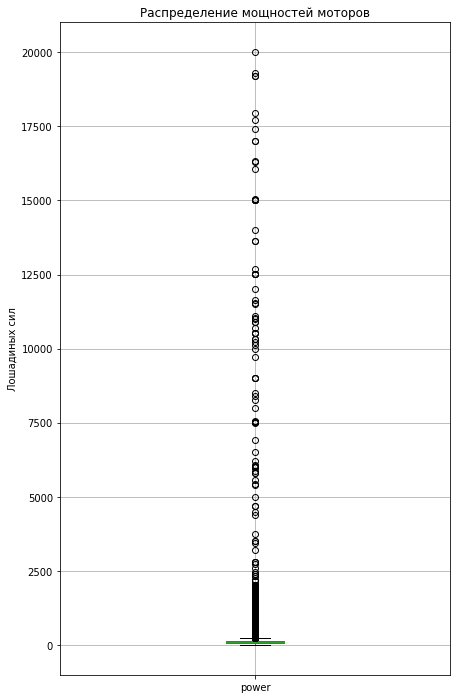

In [31]:
ax = cars_new['power'].plot(kind='box',grid=True,figsize=(7,12),title=('Распределение мощностей моторов'))
ax.set_ylabel('Лошадиных сил');

In [32]:
cars_new['power'].value_counts()

0       36315
75      22804
60      15166
150     14148
101     12732
        ...  
1625        1
1703        1
3750        1
678         1
903         1
Name: power, Length: 699, dtype: int64

Наблюдается высокий разброс величин,согласно [этой статье](https://1gai.ru/publ/510593-samye-bolshie-dvigateli-top-10.html),самый мощный двигатель из установленных на машину в районе 650 л.с

In [107]:
cars_check = cars_new.query('power>650')
len(cars_check)

327

327 записей - не так много,предлагаю их удалить

In [108]:
cars_new = cars_new.query('power<650')

Теперь посмотрим на неправдоподобно малые объемы двигателей

In [109]:
cars_new[cars_new['power']<100]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel,brand,not_repaired,pictures
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,0
16,2016-04-01 12:46:46,300,small,2016,manual,60,polo,150000,0,petrol,volkswagen,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354358,2016-04-04 09:57:12,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,0
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,0
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,0
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,0


Удалим все записи с показателями ниже 50 л.с

In [110]:
cars_new = cars_new.query('power>50')

Посмотрим колонку 'price'

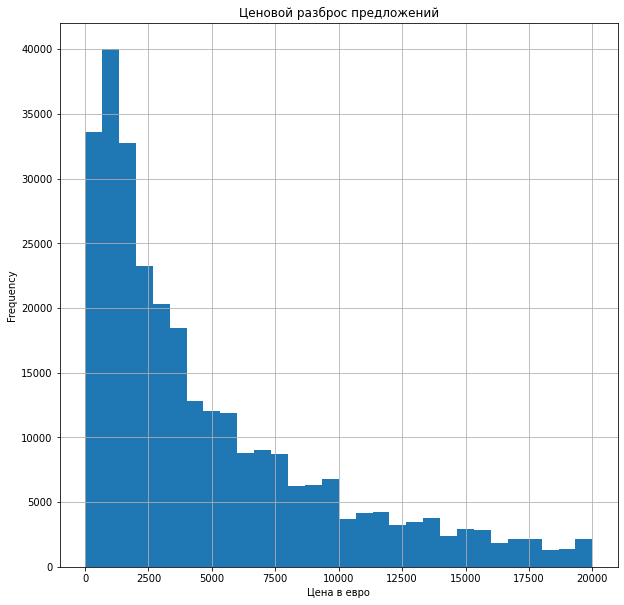

In [111]:
ax = cars_new['price'].sort_values().plot(kind='hist',bins=30,grid=True,figsize=(10,10),title=('Ценовой разброс предложений'))
ax.set_xlabel('Цена в евро');

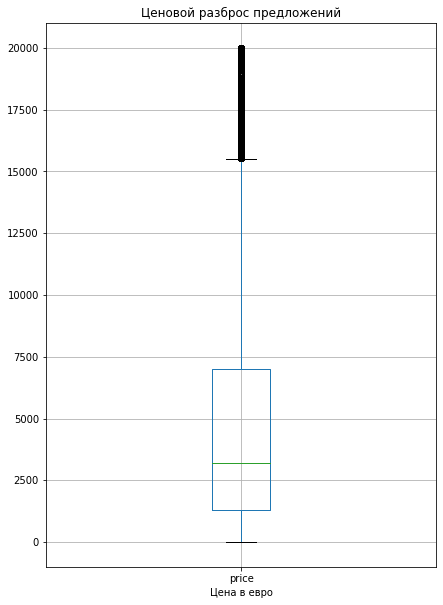

In [38]:
ax = cars_new['price'].plot(kind='box',grid=True,figsize=(7,10),title=('Ценовой разброс предложений'))
ax.set_xlabel('Цена в евро');

In [39]:
cars_new[cars_new['price'] == 0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel,brand,not_repaired,pictures
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,0
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,petrol,ford,unknown,0
466,2016-03-24 10:58:40,0,sedan,2016,auto,197,3er,150000,12,gasoline,bmw,no,0
524,2016-03-25 22:53:44,0,small,2005,manual,136,yaris,100000,10,petrol,toyota,unknown,0
563,2016-03-21 12:48:36,0,sedan,1998,auto,230,other,150000,10,petrol,saab,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354124,2016-03-27 10:37:44,0,small,2004,manual,200,golf,150000,0,petrol,volkswagen,no,0
354158,2016-03-27 16:48:25,0,small,2000,manual,55,punto,5000,5,petrol,fiat,yes,0
354205,2016-03-09 15:56:30,0,small,2000,manual,65,corsa,150000,0,petrol,opel,yes,0
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,0


Шесть тысяч запией - меньше одного процента. Поскольку данный столбец является таргетным признаком для модели, заполнять его медианами или средними лучше не стоит,т.к это повлияет на качество модели. Предлагаю так же удалить эти записи.

In [112]:
cars_new = cars_new[cars_new['price']!= 0]

Так же отбросим столбец 'date_crawled',по тем же причинам,что и другие столбцы типа datetime

In [113]:
cars_new = cars_new.drop('date_crawled',axis=1)

In [114]:
cars_new.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel,brand,not_repaired,pictures
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0


Так же стоит обратить внимание на количество фотографий в столбце 'pictures' 

In [43]:
cars_new.pictures.value_counts()

0    286740
Name: pictures, dtype: int64

Так как в нем отстутствуют какие-либо значения,предлагаю этот столбец удалить. Скорее всего данные были потеряны при выгрузе или информация о них находится в другом датасете. в любом случае сделать мы с этим ничего не можем.

In [115]:
cars_new = cars_new.drop('pictures',axis=1)

Посмотрим матрицу корреляции

In [116]:
cars_new.corr().style.background_gradient(cmap = 'coolwarm')

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.506783,0.496886,-0.394773,0.067773
registration_year,0.506783,1.000000,0.095664,-0.335777,0.043077
power,0.496886,0.095664,1.000000,0.101875,0.037933
kilometer,-0.394773,-0.335777,0.101875,1.000000,-0.016629
registration_month,0.067773,0.043077,0.037933,-0.016629,1.000000


- ожидаемо видим среднюю корреляцию цены с такими параметрами как мощность двигателя и год регистрации;
- видим отсутствие корреляции с параметром месяца регистрации ТС,его можно убрать;
- требуется перевод других важных параметров таких как марка машины и тип кузова в численный вид для оценки их корреляции с ценой.

### Кодирование категориальных признаков

Создадим два параллельных датасета,один с некодированными признаками возьмем "cars_new",вторым создадим его копию и закодируем признаки

In [117]:
cars_enc = cars_new

In [118]:
cars_enc

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel,brand,not_repaired
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,wagon,2016,auto,150,159,150000,12,petrol,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Посмотрим,сколько уникальных значений в видах коробок передач

In [119]:
cars_enc.gearbox.value_counts()

manual    228702
auto       58038
Name: gearbox, dtype: int64

Всего два вида. Тут можно воспользоваться **LabelEncoder**.

In [120]:
cars_enc['gearbox_enc'] = LabelEncoder().fit_transform(cars_enc['gearbox'])
cars_enc = cars_enc.drop('gearbox',axis=1)

In [121]:
cars_enc['gearbox_enc'].value_counts()

1    228702
0     58038
Name: gearbox_enc, dtype: int64

То же самое сделаем и для колонок 'not_repaired' и 'fuel'

In [122]:
cars_enc['not_repaired_enc'] = LabelEncoder().fit_transform(cars_enc['not_repaired'])
cars_enc['fuel_enc'] = LabelEncoder().fit_transform(cars_enc['fuel'])
cars_enc = cars_enc.drop('not_repaired',axis=1)
cars_enc = cars_enc.drop('fuel',axis=1)
cars_enc.head()

,price,vehicle_type,registration_year,power,model,kilometer,registration_month,brand,gearbox_enc,not_repaired_enc,fuel_enc
1,18300,coupe,2011,190,a4,125000,5,audi,1,2,2
2,9800,suv,2004,163,grand,125000,8,jeep,0,1,2
3,1500,small,2001,75,golf,150000,6,volkswagen,1,0,6
4,3600,small,2008,69,fabia,90000,7,skoda,1,0,2
5,650,sedan,1995,102,3er,150000,10,bmw,1,2,6


Далее,требуется кодировать категориальные текстовые признаки в колонках 'vehicle_type','gearbox','model','fuel','brand','not_repaired'

Так как категориальных переменных много в каждой из колонок,**OHE** использовать не рекомендуется - это приведет к слишком большому увеличению столбцов и, как следствие, усложнению обучения модели и увеличению времени обучения. Попробуем **OrdinalEncoding**

In [52]:
cars_new['vehicle_type'].value_counts()

sedan          87463
small          65330
wagon          60459
bus            27019
convertible    18508
coupe          14552
suv            11066
other           2343
Name: vehicle_type, dtype: int64

In [123]:
def ordinal_encoding(row):
    num_values = row.value_counts().to_list()
    names_freq = row.value_counts().index.to_list()
    scale_mapper = {}
    for i in range(len(names_freq)):
        names = names_freq[i]
        values = num_values[i]
        scale_mapper[names] = values
    return scale_mapper

In [124]:
vehicles_enc = ordinal_encoding(cars_enc['vehicle_type'])

In [125]:
cars_enc['vehicle_type_enc'] = cars_enc['vehicle_type'].replace(vehicles_enc)

Такой же метод используем и для колонoк 'brand' и 'model'

In [126]:
brand_enc = ordinal_encoding(cars_enc['brand'])
cars_enc['brand_enc'] = cars_enc['brand'].replace(brand_enc)

model_enc = ordinal_encoding(cars_enc['model'])
cars_enc['model_enc'] = cars_enc['model'].replace(model_enc)

cars_enc = cars_enc.drop(['vehicle_type','model','brand'],axis=1)

In [127]:
cars_enc.head()

,price,registration_year,power,kilometer,registration_month,gearbox_enc,not_repaired_enc,fuel_enc,vehicle_type_enc,brand_enc,model_enc
1,18300,2011,190,125000,5,1,2,2,14552,25622,9537
2,9800,2004,163,125000,8,0,1,2,11066,575,534
3,1500,2001,75,150000,6,1,0,6,65330,60249,26563
4,3600,2008,69,90000,7,1,0,2,65330,4922,1874
5,650,1995,102,150000,10,1,2,6,87463,32260,18495


> Все категориальные признаки заменены на непрерывные

In [128]:
cars_enc.corr().style.background_gradient(cmap = 'coolwarm')

,price,registration_year,power,kilometer,registration_month,gearbox_enc,not_repaired_enc,fuel_enc,vehicle_type_enc,brand_enc,model_enc
price,1.000000,0.506783,0.496886,-0.394773,0.067773,-0.255537,-0.259308,-0.286246,-0.184280,0.043071,-0.061378
registration_year,0.506783,1.000000,0.095664,-0.335777,0.043077,-0.029456,-0.137752,-0.257145,-0.019664,-0.069716,-0.169476
power,0.496886,0.095664,1.000000,0.101875,0.037933,-0.438000,-0.068099,-0.187309,-0.114310,-0.006094,-0.020025
kilometer,-0.394773,-0.335777,0.101875,1.000000,-0.016629,-0.022550,0.110401,-0.149394,0.035497,0.118770,0.084815
registration_month,0.067773,0.043077,0.037933,-0.016629,1.000000,-0.034320,-0.085466,-0.067809,0.000884,-0.001208,-0.022771
gearbox_enc,-0.255537,-0.029456,-0.438000,-0.022550,-0.034320,1.000000,0.034380,0.137999,0.026786,0.009904,0.048308
not_repaired_enc,-0.259308,-0.137752,-0.068099,0.110401,-0.085466,0.034380,1.000000,0.060415,0.027972,-0.005062,0.020377
fuel_enc,-0.286246,-0.257145,-0.187309,-0.149394,-0.067809,0.137999,0.060415,1.000000,0.087921,-0.108573,0.055254
vehicle_type_enc,-0.184280,-0.019664,-0.114310,0.035497,0.000884,0.026786,0.027972,0.087921,1.000000,0.094235,0.143502
brand_enc,0.043071,-0.069716,-0.006094,0.118770,-0.001208,0.009904,-0.005062,-0.108573,0.094235,1.000000,0.456750


К прошлым выводам по матрице корреляции добавились следующие выводы:
- Модель машины имеет среднюю корреляцию с ценой;
- Так же более слабую корреляцию с ценой на машину имеют следующие параметры - тип кузова и бренд.
- Остальные имеют слабую обратную корреляцию

### Разделение и скалирование признаков

Разделим признаки

In [129]:
target_enc,target = cars_enc['price'],cars_new['price']
features_enc,features = cars_enc.drop('price',axis=1),cars_new.drop('price',axis=1)

Так же для уравнения весов признаков, стоит их перевести в более близкие размерности после разделения датафрейма на выборки и признаки

In [130]:
column = features_enc.columns
column

Index(['registration_year', 'power', 'kilometer', 'registration_month',
       'gearbox_enc', 'not_repaired_enc', 'fuel_enc', 'vehicle_type_enc',
       'brand_enc', 'model_enc'],
      dtype='object')

In [131]:
features_train,features_test,target_train,target_test = train_test_split(features,target, test_size=.2,
                                                                         random_state=12345, shuffle=True)

features_train_enc,features_test_enc,target_train_enc,target_test_enc = train_test_split(features_enc,target_enc, test_size=.2,
                                                                         random_state=12345, shuffle=True)

print(features_train.shape,' / ',features_train_enc.shape)
print(target_train.shape,'  / ',target_train_enc.shape)

print(features_test.shape,'/',features_test_enc.shape)
print(target_test.shape,' / ',target_test_enc.shape)

(229392, 11)  /  (229392, 10)
(229392,)   /  (229392,)
(57348, 11) / (57348, 10)
(57348,)  /  (57348,)


In [132]:
scaler = StandardScaler()
scaler.fit(features_train_enc[column])

features_train_enc[column] = scaler.transform(features_train_enc[column])
features_test_enc[column] = scaler.transform(features_test_enc[column])

In [133]:
features_train_enc.head()

,registration_year,power,kilometer,registration_month,gearbox_enc,not_repaired_enc,fuel_enc,vehicle_type_enc,brand_enc,model_enc
100260,-0.165832,-1.192466,-1.322937,-0.002219,-1.981697,2.581878,0.682728,0.233922,-1.207068,-0.813269
226794,1.271121,0.032627,-0.776625,-0.841099,0.504618,-0.519206,0.682728,1.087003,-0.395965,-0.315211
271915,0.153491,0.748834,0.589152,-1.679979,-1.981697,-0.519206,-0.401095,1.087003,-0.021777,-0.275070
33841,0.792137,-0.419715,-0.776625,1.116288,0.504618,-0.519206,-1.484918,-1.242713,0.171787,-0.872644
131081,-0.804477,-1.324399,-0.093736,-1.120725,0.504618,1.031336,0.682728,0.233922,-1.312275,-0.914338


## Обучение моделей

In [134]:
def rmse (target, predicted):
    return  mean_squared_error(target, predicted, squared=False)

In [135]:
my_scorer= make_scorer(rmse)

In [136]:
state = np.random.RandomState(12345)

### Linear Regression

Для начала посмотрим линейную регрессию

In [67]:
%%time
linear = LinearRegression()

rmse_linear= cross_val_score(linear, features_train_enc, target_train_enc, 
                             scoring = my_scorer,
                             cv = 5,).mean()

print('RMSE : ',rmse_linear)

RMSE :  2853.754753175459
CPU times: user 621 ms, sys: 603 ms, total: 1.22 s
Wall time: 1.17 s


### Random Forest Regressor

In [66]:
%%time
random_forest = RandomForestRegressor(random_state = state)

params_grid = {
            'n_estimators' : range(10,100,10),
            'max_depth' : range(5,30,5),
        }
grid_search = GridSearchCV(estimator = random_forest, param_grid = params_grid, 
                                   cv = 5, scoring = my_scorer)

grid_search.fit(features_train_enc, target_train_enc)

print(grid_search.best_params_)
print('RMSE : ',grid_search.best_score_)

KeyboardInterrupt: 

### DecisionTreeRegressor

In [67]:
%%time
decision_tree =  DecisionTreeRegressor(random_state = state)

params_grid = {
            'max_depth' : range(5, 30,5),
            'min_samples_split' :  range(0,10,1)}
grid_search = GridSearchCV(estimator = decision_tree, param_grid = params_grid, 
                                   cv = 5, scoring = my_scorer)

grid_search.fit(features_train_enc, target_train_enc)

print(grid_search.best_params_)
print('RMSE : ',grid_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-

KeyboardInterrupt: 

### ExtraTreesRegressor

In [68]:
%%time
decision_tree =  ExtraTreesRegressor(random_state = state)

params_grid = {
            'n_estimators' : range(10,100,10),
            'max_depth' :  range(5, 30,5),
        }
grid_search = GridSearchCV(estimator = decision_tree, param_grid = params_grid, 
                                   cv = 5, scoring = my_scorer)

grid_search.fit(features_train_enc, target_train_enc)

print(grid_search.best_params_)
print('RMSE : ',grid_search.best_score_)

KeyboardInterrupt: 

### Выводы по опробованным моделям

**LinearRegression**

- RMSE :  **2860.24518** - самая высокая степень ошибки
- CPU times: user 533 ms, sys: 617 ms, total: 1.15 s
- Wall time: 1.09 s

Лучшие параметры для **RandomForestRegressor**:

- 'max_depth': 5,
- 'n_estimators': 10
- RMSE :  **2393.5605**
- CPU times: user 1h 8min 39s, sys: 28.4 s, total: 1h 9min 8s
- Wall time: **1h 9min 19s** - крайне долгое время обучения для rmse такой величины

Лучшие параметры для **DecisionTreeRegressor**:

{'max_depth': 5, 'min_samples_split': 2}
- RMSE :  **2433.3153**
- CPU times: user 1min 50s, sys: 219 ms, total: 1min 50s
- Wall time: **1min 51s**- **быстрый** подбор параметров


Лучшие параметры для **ExtraTreesRegressor**:

- 'max_depth': 5,
- 'n_estimators': 80
- **RMSE :2637.07428** - **высокая** степень ошибки
- CPU times: user 34min 54s, sys: 30.7 s, total: 35min 25s - **долгое** время реализации
- Wall time: 43min 17s

> Все модели дают крайне высокие погрешности,недопустимые для оценки цены авто. Скорость исполнения и подбора лучших гиперпараметров у моделей  **RandomForestRegressor** и **ExtraTreesRegressor** довольно долгая. И с увеличением датасета будет становиться ещё больше. Далем вывод,что проверенные модели не подходят для точной количественной оценки стоимости машины исходя из признаков. На тестовой выборке значения получатся с ещё более высокой погрешностью.

Теперь попробуем обучить модели на основе градиентного бутинга

## Обучение моделей (Lightgbm,catboost)

Для моделей градиентного бустинга не обязательно кодировать признаки. Достаточно будет перевести категориальные признаки к типу category

In [68]:
cars_new.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel,brand,not_repaired,gearbox_enc
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,1
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,1
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,1


Отделим категориальные колонки для моделей,т.к. в CatBoost их нужно указывать списком, а в LGBM 

In [137]:
categorial_columns =['vehicle_type','gearbox','model','fuel','brand','not_repaired']

In [138]:
num_cols = ['registration_year','power','kilometer','registration_month']

In [139]:
features_train[categorial_columns] = features_train[categorial_columns].astype('category')

In [140]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229392 entries, 100260 to 268859
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        229392 non-null  category
 1   registration_year   229392 non-null  int64   
 2   gearbox             229392 non-null  category
 3   power               229392 non-null  int64   
 4   model               229392 non-null  category
 5   kilometer           229392 non-null  int64   
 6   registration_month  229392 non-null  int64   
 7   fuel                229392 non-null  category
 8   brand               229392 non-null  category
 9   not_repaired        229392 non-null  category
 10  gearbox_enc         229392 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 12.0 MB


Выборки разделены нормально

### LGBMRegressor

In [74]:
%%time
lgbm_model = LGBMRegressor(random_state = state,n_jobs = -1)
    
param_grid = {'max_depth':range(10,36,5),
              'learning_rate':[0.02,0.04,1]}
    
lgbm_grid = GridSearchCV(lgbm_model,param_grid,
                             scoring = 'neg_root_mean_squared_error',
                             cv =5, verbose = 10)
lgbm_grid.fit(features_train,target_train);
print('Лучший результат LGBM:',lgbm_grid.best_score_)
print( lgbm_grid.best_estimator_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START learning_rate=0.02, max_depth=10...........................


KeyboardInterrupt: 

Лучший результат LGBM: 
- RMSE: **-1702.4035**
- learning_rate=1, 
- max_depth=10,
- CPU times: user 12min 57s, sys: 2.7 s, total: 13min
- Wall time: 13min 7s


Попробуем модель с полученными параметрами

In [75]:
%%time
lgbm_train =  LGBMRegressor(learning_rate=1, max_depth=10, random_state = state,n_jobs = 4)

rmse_train = cross_val_score(lgbm_train, features_train, target_train, 
                                    scoring = 'neg_root_mean_squared_error',
                                    cv = 5).mean()


print('RMSE на обучающей выборке: ', rmse_train)

KeyboardInterrupt: 

- RMSE на обучающей выборке:  **1702.4035**
- CPU times: user 8.22 s, sys: 64.7 ms, total: 8.28 s
- Wall time: **8.3 s**

> Погрешность довольно высокая

### CatBoostRegressor

In [141]:
features_train[categorial_columns] = features_train[categorial_columns].astype(str)

In [142]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229392 entries, 100260 to 268859
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicle_type        229392 non-null  object
 1   registration_year   229392 non-null  int64 
 2   gearbox             229392 non-null  object
 3   power               229392 non-null  int64 
 4   model               229392 non-null  object
 5   kilometer           229392 non-null  int64 
 6   registration_month  229392 non-null  int64 
 7   fuel                229392 non-null  object
 8   brand               229392 non-null  object
 9   not_repaired        229392 non-null  object
 10  gearbox_enc         229392 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 21.0+ MB


In [143]:
train_df = cb.Pool(features_train, target_train,cat_features=categorial_columns) 
test_df = cb.Pool(features_test, target_test,cat_features=categorial_columns)

In [79]:
%%time
cbr_model = CatBoostRegressor(loss_function='RMSE',cat_features=categorial_columns)
grid = {'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
cbr_model.grid_search(grid,train_df,refit=True,verbose=10,)
print(" Results from Grid Search " )
print("\n The best params across ALL searched params:\n",cbr_model.get_all_params())
print("\n The best score across ALL searched params:\n",cbr_model.get_best_score())
print("\n The best iteration across ALL searched :\n",cbr_model.get_best_iteration())

0:	learn: 6641.8628968	test: 6590.1640530	best: 6590.1640530 (0)	total: 81.1ms	remaining: 1m 21s
1:	learn: 6491.0509665	test: 6439.9102516	best: 6439.9102516 (1)	total: 159ms	remaining: 1m 19s
2:	learn: 6346.7233733	test: 6296.2869231	best: 6296.2869231 (2)	total: 233ms	remaining: 1m 17s
3:	learn: 6206.7846587	test: 6156.5613905	best: 6156.5613905 (3)	total: 292ms	remaining: 1m 12s
4:	learn: 6072.1614601	test: 6022.2516106	best: 6022.2516106 (4)	total: 337ms	remaining: 1m 7s
5:	learn: 5941.6457983	test: 5892.3319323	best: 5892.3319323 (5)	total: 381ms	remaining: 1m 3s
6:	learn: 5815.7737493	test: 5766.8753946	best: 5766.8753946 (6)	total: 445ms	remaining: 1m 3s
7:	learn: 5694.8111287	test: 5646.1908675	best: 5646.1908675 (7)	total: 486ms	remaining: 1m
8:	learn: 5578.5757625	test: 5530.5000732	best: 5530.5000732 (8)	total: 530ms	remaining: 58.4s
9:	learn: 5465.3605069	test: 5417.9148497	best: 5417.9148497 (9)	total: 579ms	remaining: 57.4s
10:	learn: 5356.5475762	test: 5309.8034242	best:

AttributeError: 'GridSearchCV' object has no attribute 'get_all_params'

The best params across ALL searched params:
 {'nan_mode': 'Min', 'eval_metric': 'RMSE', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 0.20000000298023224, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 8, 'ctr_target_border_count': 1, 'posterior_sampling': False, 'has_time': False, 'store_all_simple_ctr': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.029999999329447743, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 256, 'permutation_count': 4}

The best score across ALL searched params:
- 'RMSE': **1523.6632**

The best parameters across ALL searched params:
 - 'depth': 8, 
 - 'l2_leaf_reg': 0.2
- CPU times: user **1h 27min 53s**, sys: 28.1 s, total: 1h 28min 21s
- Wall time: 1h 29min 32s

In [144]:
%%time
cbr_train =  CatBoostRegressor(loss_function='RMSE',cat_features=categorial_columns,
                               depth=8,l2_leaf_reg= 0.2)

rmse_train = cross_val_score(cbr_train , features_train, target_train, 
                                    scoring = 'neg_root_mean_squared_error',
                                    cv = 3, n_jobs = -1).mean()


print('RMSE на обучающей выборке: ', rmse_train)

0:	learn: 4536.0485829	total: 360ms	remaining: 5m 59s
1:	learn: 4440.7954373	total: 654ms	remaining: 5m 26s
2:	learn: 4349.9687135	total: 903ms	remaining: 5m
3:	learn: 4261.6344373	total: 1.16s	remaining: 4m 48s
4:	learn: 4178.5277293	total: 1.39s	remaining: 4m 36s
5:	learn: 4096.1520185	total: 1.65s	remaining: 4m 32s
6:	learn: 4015.9583981	total: 1.88s	remaining: 4m 26s
7:	learn: 3939.3463983	total: 2.16s	remaining: 4m 28s
8:	learn: 3864.2503855	total: 2.41s	remaining: 4m 25s
9:	learn: 3793.5653452	total: 2.61s	remaining: 4m 18s
10:	learn: 3723.1701457	total: 2.84s	remaining: 4m 15s
11:	learn: 3657.3963197	total: 3.1s	remaining: 4m 15s
12:	learn: 3592.0785682	total: 3.38s	remaining: 4m 16s
13:	learn: 3530.3375083	total: 3.62s	remaining: 4m 15s
14:	learn: 3469.6296146	total: 3.86s	remaining: 4m 13s
15:	learn: 3410.8939606	total: 4.1s	remaining: 4m 12s
16:	learn: 3354.5949362	total: 4.39s	remaining: 4m 13s
17:	learn: 3301.6221948	total: 4.64s	remaining: 4m 13s
18:	learn: 3248.9828899	to

- **RMSE** на обучающей выборке:  **1609.4246**
- CPU times: user 8min 46s, sys: 2.36 s, total: 8min 48s
- Wall time: **8min 56s**

### Результаты


#### LGBMRegressor

**На подборе гиперпараметров**

- RMSE: -1702.4035
- learning_rate=1,
- max_depth=10,
- CPU times: user 12min 57s, sys: 2.7 s, total: 13min
- Wall time: 13min 7s

**На обучающей выборке**

- RMSE на обучающей выборке:  **1702.4035**
- CPU times: user 8.22 s, sys: 64.7 ms, total: 8.28 s
- Wall time: **8.3 s**

#### CatBoostRegressor

**На подборе гиперпараметров**

The best score across ALL searched params:
- 0.8791972327801099

The best parameters across ALL searched params:
 - 'depth': 8, 
 - 'l2_leaf_reg': 0.2
- CPU times: user **1h 27min 53s**, sys: 28.1 s, total: 1h 28min 21s
- Wall time: 1h 29min 32s

**На обучающей выборке**

- **RMSE** на обучающей выборке:  **1609.4246**
- CPU times: user 8min 46s, sys: 2.36 s, total: 8min 48s
- Wall time: **8min 56s**

> Самая малая погрешность получилась у CatBoostRegressor

## Анализ моделей

### Тестовая выборка

In [132]:
%%time
#cbr_test =  CatBoostRegressor(loss_function='RMSE',cat_features=categorial_columns,
 #                              depth=8,l2_leaf_reg= 0.2)
#cbr_model.fit(test_df,eval_set = train_df)
predictions = cbr_nodel.predict(target_test)


0:	learn: 4530.7853393	test: 4535.8938223	best: 4535.8938223 (0)	total: 346ms	remaining: 5m 45s
1:	learn: 4437.4767246	test: 4442.6085088	best: 4442.6085088 (1)	total: 688ms	remaining: 5m 43s
2:	learn: 4347.6941858	test: 4352.6999550	best: 4352.6999550 (2)	total: 966ms	remaining: 5m 20s
3:	learn: 4261.7122825	test: 4266.7993107	best: 4266.7993107 (3)	total: 1.29s	remaining: 5m 22s
4:	learn: 4177.6761259	test: 4182.7770666	best: 4182.7770666 (4)	total: 1.48s	remaining: 4m 55s
5:	learn: 4096.0509051	test: 4101.1565622	best: 4101.1565622 (5)	total: 1.78s	remaining: 4m 55s
6:	learn: 4016.9665190	test: 4021.9487618	best: 4021.9487618 (6)	total: 2.08s	remaining: 4m 54s
7:	learn: 3940.6953999	test: 3945.9098664	best: 3945.9098664 (7)	total: 2.28s	remaining: 4m 42s
8:	learn: 3865.9137059	test: 3871.4973063	best: 3871.4973063 (8)	total: 2.59s	remaining: 4m 45s
9:	learn: 3794.4557994	test: 3799.9370897	best: 3799.9370897 (9)	total: 2.94s	remaining: 4m 51s
10:	learn: 3725.8624841	test: 3731.50386

KeyError: 0

- **RMSE** на тестовой выборке:  **1642.6740**
- Wall time: 5m 45s

- На обычных регресионных моделях качество получалось заметно хуже - **RMSE 2300-2600**
- Время обучения было самым малым у модели **линейной регрессии**
- Модели градиентного бустинга показали себя гораздо лучше.
- Самая низкая погрешность получилась у модели **CatBoostRegressor** - **RMSE** на тестовой выборке: **1642.6740**